# Setting

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score

## 데이터 불러오기

In [2]:
# 데이터 불러오기
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

print(iris_df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


# 데이터 분포 확인

In [3]:
print(iris_df.describe())

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  


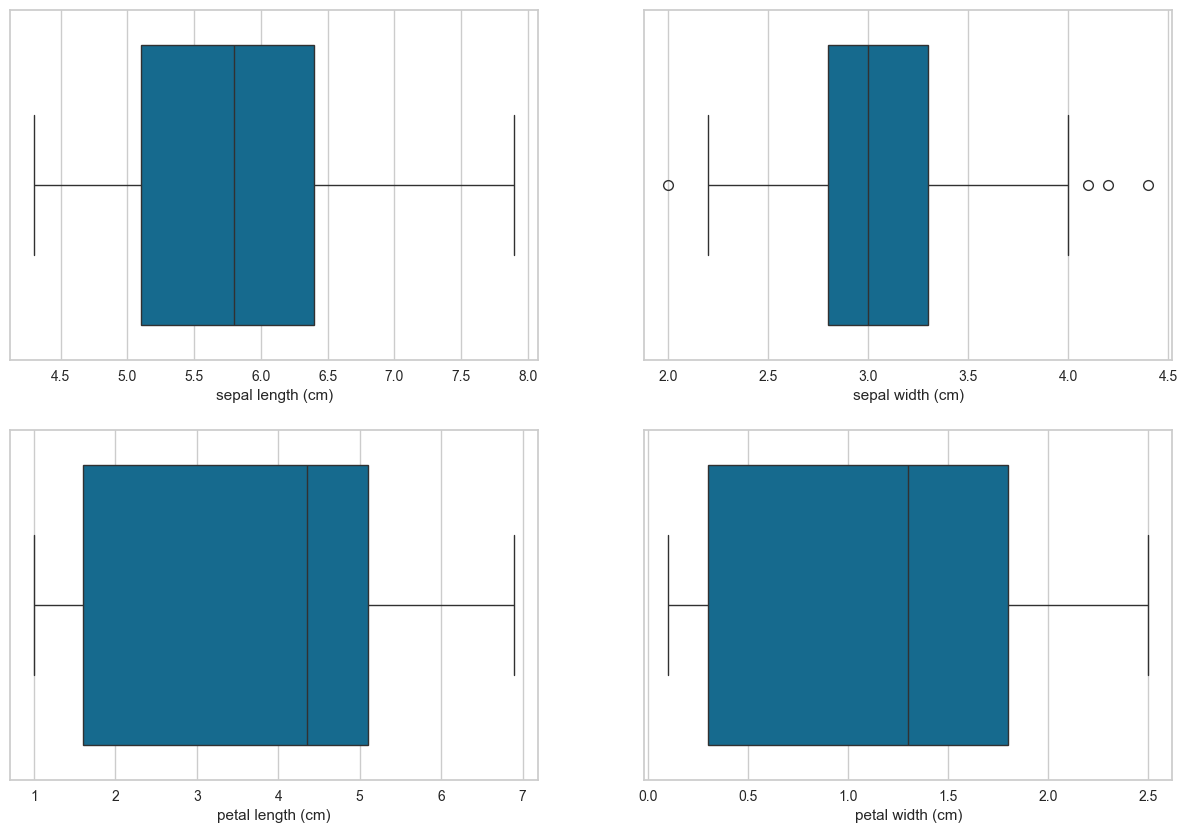

In [4]:
# 박스 플랏 확인
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='sepal length (cm)', data=iris_df)

plt.subplot(2, 2, 2)
sns.boxplot(x='sepal width (cm)', data=iris_df)

plt.subplot(2, 2, 3)
sns.boxplot(x='petal length (cm)', data=iris_df)

plt.subplot(2, 2, 4)
sns.boxplot(x='petal width (cm)', data=iris_df)

plt.show()

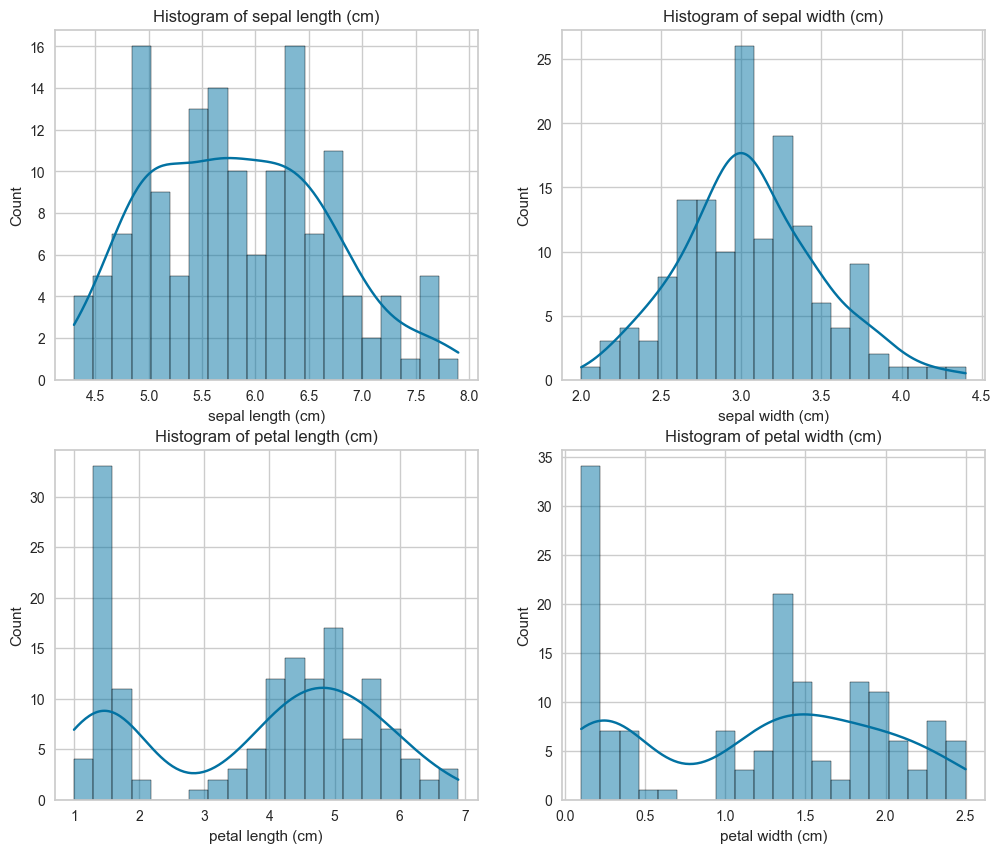

In [5]:
# 히스토그램
selected_features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

plt.figure(figsize=(12, 10))

for i, feature in enumerate(selected_features, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(iris_df[feature], bins=20, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    
plt.show()

군집 분석은 몇 개의 군집으로 나눌 것인지 임의로 결정해주어야 하여

개수를 설정하는데에 데이터에 대한 이해와 도메인에 대한 지식이 필요함

In [6]:
# 군집 분석에 필요한 컬럼 추출
X = iris_df.iloc[:, :4]

In [7]:
# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Elbow Method를 통한 k값 결정

Elbow Method : 최적의 군집 개수를 찾는 방법  
distortion score가 꺽이는 구간(팔꿈치, Elbow)가 최적의 군집 개수 - 꺽이는 구간에 대한 주관적인 견해가 들어갈 수 있음  
distortion score는 SSE(오차제곱합)  

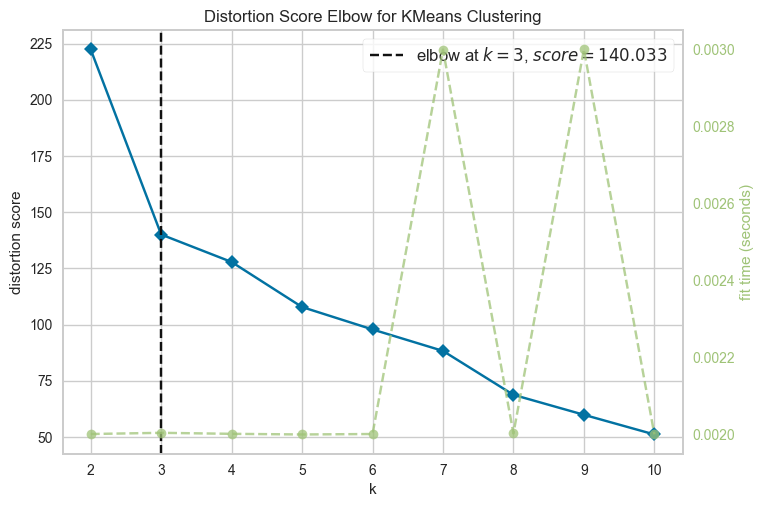

Optimal number of clusters (k): 3


In [19]:
# seed = 33, k = (2,11)
kmeans_default = KMeans(random_state=33)
visualizer = KElbowVisualizer(kmeans_default, k=(2, 11))
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal number of clusters (k):", optimal_k)

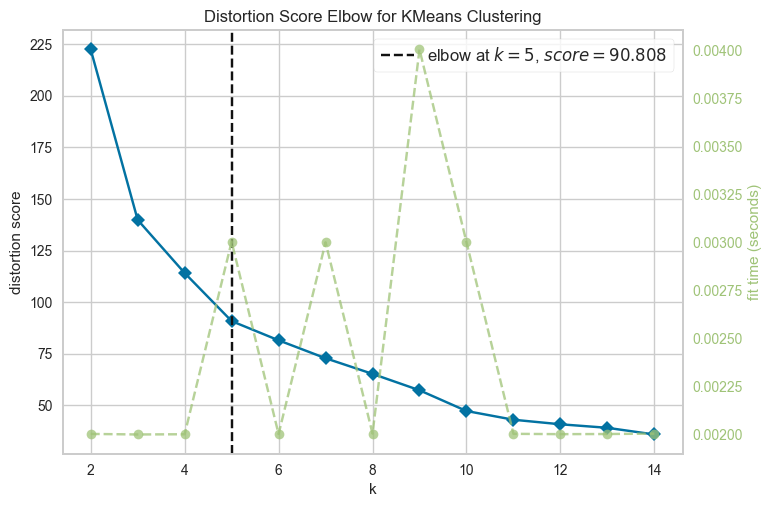

Optimal number of clusters (k): 5


In [25]:
# seed = 0, k = (2,15)
kmeans_default = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans_default, k=(2, 15))
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal number of clusters (k):", optimal_k)

시드와 k의 범위에 따라 optimal_k값이 변하여 주관적인 판단이 필요함  
3에서 꺽이는 정도가 가장 크다고 판단되며, iris 데이터의 실제 target 종류도 3종류이기 때문에 k를 3으로 결정함

## Model

In [26]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters = 3, random_state=0)
kmeans.fit(X_scaled)

# 군집 결과를 데이터프레임에 추가
iris_df['cluster'] = kmeans.labels_

## 실루엣 계수

개별 데이터가 할당된 군집 내 데이터와 얼마나 가깝게 군집화 되어있는지,   
다른 군집에 있는 데이터와는 얼마나 멀리 분리되어 있는지  
즉 얼마나 군집이 잘 되었는지 확인할 수 있는 값  

-1부터 1까지의 값을 가지며 1에 가까울수록 최적화된 군집임  
일반적으로 0.5 이상 : 좋음, 0.7 이상 : 매우 좋음  

In [27]:
# 실루엣 스코어 확인
silhouette_avg = silhouette_score(X_scaled, iris_df['cluster'])
print("평균 실루엣 스코어:", silhouette_avg)

평균 실루엣 스코어: 0.45994823920518635


0.46로 조금 낮은 실루엣 스코어를 보임

## 시드 탐색

In [28]:
best_seed = None
best_score = -1

# 시드를 0부터 99까지 변화시키면서 반복 수행
for seed in range(100):
    kmeans = KMeans(n_clusters=3, random_state=seed)
    kmeans.fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    
    # 현재 시드에 대한 실루엣 스코어가 더 높으면 기록
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_seed = seed

# 가장 좋은 시드 출력
print("Best seed:", best_seed)
print("Best silhouette score:", best_score)

Best seed: 9
Best silhouette score: 0.4798814508199817


In [29]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters = 3, random_state=best_seed)
kmeans.fit(X_scaled)

# 군집 결과를 데이터프레임에 추가
iris_df['cluster'] = kmeans.labels_

# 실루엣 스코어 확인
silhouette_avg = silhouette_score(X_scaled, iris_df['cluster'])
print("평균 실루엣 스코어:", silhouette_avg)

평균 실루엣 스코어: 0.4798814508199817


실루엣 스코어를 약 0.48로 보완함

In [30]:
iris_df['match'] = iris_df.apply(lambda row: row['target'] == row['cluster'], axis=1)
print(iris_df.head())

# 파일 저장
iris_df.to_csv('kmeans_iris.csv', encoding='utf-8-sig',index=False)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  cluster  match  
0       0        2  False  
1       0        0   True  
2       0        0   True  
3       0        0   True  
4       0        2  False  


In [31]:
print('실제 클래스와 예측 클래스의 일치율은', sum(iris_df['match'])/150 * 100, '% 입니다')

실제 클래스와 예측 클래스의 일치율은 42.0 % 입니다
